<a href="https://colab.research.google.com/github/AirNicco8/NLP_Unibo_Project_Work/blob/main/SetFit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [1]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.0 MB/s 
     |████████████████████████████████| 5.3 MB 49.1 MB/s 
     |████████████████████████████████| 1.3 MB 49.3 MB/s 
     |████████████████████████████████| 163 kB 66.4 MB/s 
     |████████████████████████████████| 7.6 MB 61.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=46e9d070b0f5433572d2840590b2784b034bdec0fb4b329f8a61d5e64d2a9f31
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [73]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [3]:
def sentence_pairs_generation(sentences, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if a pair is positive or negative

  numClassesList = np.unique(labels)
  idx = [np.where(labels == i)[0] for i in numClassesList]

  for idxA in range(len(sentences)):      
    currentSentence = sentences[idxA]
    label = labels[idxA]
    idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
    posSentence = sentences[idxB]
		  # prepare a positive pair and update the sentences and labels
		  # lists, respectively
    pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0))

    negIdx = np.where(labels != label)[0]
    negSentence = sentences[np.random.choice(negIdx)]
		  # prepare a negative pair of images and update our lists
    pairs.append(InputExample(texts=[currentSentence, negSentence], label=0.0))
  
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [4]:
def clean(df):
  df['text'] = df['text'].str.replace(r'\s*@\w+ ', '', regex=True).replace(r'\\+@\w+', '', regex=True).replace(r'\\+@\w+ ', '', regex=True) # remove mentions
  df['text'] = df['text'].replace(r'http\S+', '', regex=True).replace(r'http\S+ ', '', regex=True).replace(r'www\S+ ', '', regex=True) # remove links
  return df

In [44]:
def eval(x_train, x_eval, y_train, y_eval):
  print("-------------- No Fit --------------")
  X_train_noFT = orig_model.encode(x_train)
  X_eval_noFT = orig_model.encode(x_eval)

  if(classifier == "LogisticRegression"):
    sgd =  LogisticRegression()
    sgd.fit(X_train_noFT, y_train)
    y_pred_eval_sgd = sgd.predict(X_eval_noFT)
  else:
    clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
    clf.fit(X_train_noFT, y_train)
    y_pred_eval_sgd = clf.predict(X_eval_noFT)

  print('Acc. No Fit', accuracy_score(y_eval, y_pred_eval_sgd))
  print('F1 No Fit', f1_score(y_eval, y_pred_eval_sgd))
  print('')
  print("Report")
  target_names = ['other', 'political']
  print(classification_report(y_eval, y_pred_eval_sgd, target_names=target_names))

  cnf_matrix = confusion_matrix(y_eval, y_pred_eval_sgd)

  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('NoFit Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print("-----------------------------------------")
  print('')
  print("-------------- With SetFit --------------")
  X_train = model.encode(x_train)
  X_eval = model.encode(x_eval)

  if(classifier == "LogisticRegression"):
    sgd =  LogisticRegression()
    sgd.fit(X_train, y_train)
    y_pred_eval_sgd = sgd.predict(X_eval)
  else:
    clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
    clf.fit(X_train, y_train)
    y_pred_eval_sgd = clf.predict(X_eval)

  print('Acc. SetFit', accuracy_score(y_eval, y_pred_eval_sgd))
  print('F1 SetFit', f1_score(y_eval, y_pred_eval_sgd))
  print('')
  print("Report")
  target_names = ['other', 'political']
  print(classification_report(y_eval, y_pred_eval_sgd, target_names=target_names))

  cnf_matrix = confusion_matrix(y_eval, y_pred_eval_sgd)

  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('SetFit Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print("-----------------------------------------")
  print('')

  #Plot 2-D 2x2 figures
  if plot2d_checkbox:   
    plt.figure(figsize=(20,10))

  #Plot X_train_noFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train_noFT))
    plt.subplot(221)
    plt.title('X_train No Fit')

    for i, t in enumerate(set(np.array(y_train))):
        idx = np.array(y_train) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));

  #Plot X_eval noFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval_noFT))
    plt.subplot(223)
    plt.title('X_eval No Fit')

    for i, t in enumerate(set(np.array(y_eval))):
        idx = np.array(y_eval) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));


  #Plot X_train SetFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train))

    plt.subplot(222)
    plt.title('X_train SetFit')

    for i, t in enumerate(set(np.array(y_train))):
        idx = np.array(y_train) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));

  #Plot X_eval SetFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval))
    plt.subplot(224)
    plt.title('X_eval SetFit')

    for i, t in enumerate(set(np.array(y_eval))):
        idx = np.array(y_eval) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));


# Multi Language student (it-en-de)

## Italian Text Classification

### CSV Download + basic cleaning

In [5]:
#SENTIPOLC
# Load Sentipolc training dataset into a pandas dataframe.
ita_train_df = clean(pd.read_csv('https://raw.githubusercontent.com/AirNicco8/NLP_Unibo_Project_Work/main/data/training_set_sentipolc16.csv', delimiter=',', header=0))

In [6]:
# Load the test dataset into a pandas dataframe.
ita_eval_df = clean(pd.read_csv('https://raw.githubusercontent.com/AirNicco8/NLP_Unibo_Project_Work/main/data/test_set_sentipolc16_gold2000.csv', delimiter=',', header=0, on_bad_lines='skip'))

In [7]:
# we just keep the text column and the topic label (1 for politics and 0 for other)
ita_train_df.drop(columns=ita_train_df.columns.values[:-2], inplace = True)
ita_eval_df.drop(columns=ita_eval_df.columns.values[:-2], inplace = True)

In [8]:
# in the eval dataframe the politics label is 2, so we map to 1
ita_eval_df.top = ita_eval_df.top.map({2:1, 0:0})

In [61]:
values, count = np.unique(ita_eval_df.top.values, return_counts=True)
values, count # classes are heavily unbalanced in test set

(array([0, 1]), array([ 482, 1460]))

In [ ]:
balanced_ita_eval_df = ita_eval_df[ita_eval_df['top']==0]
balanced_ita_eval_df = pd.concat([balanced_ita_eval_df, ita_train_df[ita_train_df['top']==1].sample(len(balanced_ita_eval_df))])
balanced_ita_eval_df # create a balanced dataset for evaluation

In [56]:
text_col = balanced_ita_eval_df.columns.values[1] 
category_col = balanced_ita_eval_df.columns.values[0]

x_eval = balanced_ita_eval_df[text_col].values.tolist()
y_eval = balanced_ita_eval_df[category_col].values.tolist()

### Parallel Dataset & Params

In [62]:
st_model = "airnicco8/xlm-roberta-en-it-de" #@param ["airnicco8/xlm-roberta-en-it-de"]
num_training = 32 #@param ["8", "16", "32", "64", "128", "256", "512"] {type:"raw"}
num_itr = 5 #@param ["1", "2", "3", "4", "5", "10"] {type:"raw"}
classifier = "SGDClassifier" #@param ["LogisticRegression", "SGDClassifier"]
plot2d_checkbox = True #@param {type: 'boolean'}

set_seed(0)
# Equal samples per class training
train_df_sample = pd.concat([ita_train_df[ita_train_df[category_col]==0].sample(num_training), ita_train_df[ita_train_df[category_col]==1].sample(num_training)])
x_train = train_df_sample[text_col].values.tolist()
y_train = train_df_sample[category_col].values.tolist()

train_examples = [] 
for x in range(num_itr):
  train_examples = sentence_pairs_generation(np.array(x_train), np.array(y_train), train_examples)


In [63]:
len(train_examples)

640

### Ita Training

In [64]:
orig_model = SentenceTransformer(st_model)
model = SentenceTransformer(st_model)

# S-BERT adaptation 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=10, show_progress_bar=True)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

### Ita Evaluation

-------------- No Fit --------------
Acc. No Fit 0.8340248962655602
F1 No Fit 0.8297872340425531

Report
              precision    recall  f1-score   support

       other       0.82      0.86      0.84       482
   political       0.85      0.81      0.83       482

    accuracy                           0.83       964
   macro avg       0.83      0.83      0.83       964
weighted avg       0.83      0.83      0.83       964

-----------------------------------------

-------------- With SetFit --------------
Acc. SetFit 0.9761410788381742
F1 SetFit 0.9764585465711362

Report
              precision    recall  f1-score   support

       other       0.99      0.96      0.98       482
   political       0.96      0.99      0.98       482

    accuracy                           0.98       964
   macro avg       0.98      0.98      0.98       964
weighted avg       0.98      0.98      0.98       964

-----------------------------------------



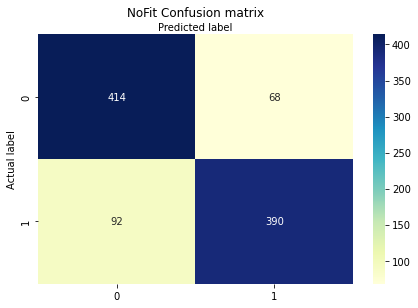

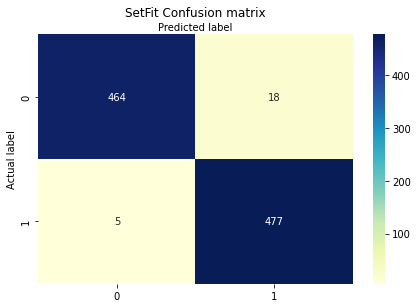

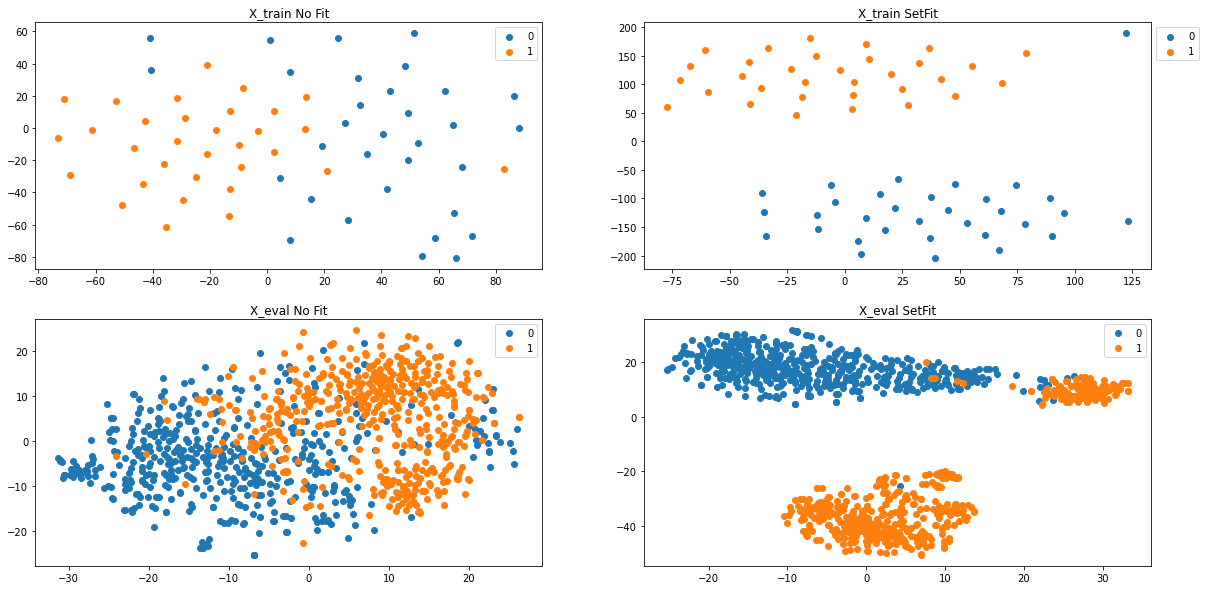

In [65]:
eval(x_train, x_eval, y_train, y_eval)

## English Text Classification

### Eng Data Preparation

In [49]:
#SST-2
# Load SST-2 dataset into a pandas dataframe.
eng_train_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

# Load the test dataset into a pandas dataframe.
eng_eval_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

In [66]:
text_col=eng_train_df.columns.values[0] 
category_col=eng_train_df.columns.values[1]

x_eval = eng_eval_df[text_col].values.tolist()
y_eval = eng_eval_df[category_col].values.tolist()

### Parallel Dataset & Params

In [70]:
st_model = "airnicco8/xlm-roberta-en-it-de" #@param ["airnicco8/xlm-roberta-en-it-de"]
num_training = 32 #@param ["8", "16", "32", "64", "128", "256", "512"] {type:"raw"}
num_itr = 5 #@param ["1", "2", "3", "4", "5", "10"] {type:"raw"}
classifier = "SGDClassifier" #@param ["LogisticRegression", "SGDClassifier"]
plot2d_checkbox = True #@param {type: 'boolean'}

set_seed(0)
# Equal samples per class training
train_df_sample = pd.concat([eng_train_df[eng_train_df[1]==0].sample(num_training), eng_train_df[eng_train_df[1]==1].sample(num_training)])
x_train = train_df_sample[text_col].values.tolist()
y_train = train_df_sample[category_col].values.tolist()

train_examples = [] 
for x in range(num_itr):
  train_examples = sentence_pairs_generation(np.array(x_train), np.array(y_train), train_examples)


In [68]:
len(train_examples)

640

### Eng Training

In [69]:
orig_model = SentenceTransformer(st_model)
model = SentenceTransformer(st_model)

# S-BERT adaptation 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=10, show_progress_bar=True)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

### Eng Evaluation

-------------- No Fit --------------
Acc. No Fit 0.7484898407468424
F1 No Fit 0.7447045707915274

Report
              precision    recall  f1-score   support

       other       0.74      0.76      0.75       912
   political       0.75      0.73      0.74       909

    accuracy                           0.75      1821
   macro avg       0.75      0.75      0.75      1821
weighted avg       0.75      0.75      0.75      1821

-----------------------------------------

-------------- With SetFit --------------
Acc. SetFit 0.8412959912136189
F1 SetFit 0.8351397604107245

Report
              precision    recall  f1-score   support

       other       0.82      0.88      0.85       912
   political       0.87      0.81      0.84       909

    accuracy                           0.84      1821
   macro avg       0.84      0.84      0.84      1821
weighted avg       0.84      0.84      0.84      1821

-----------------------------------------



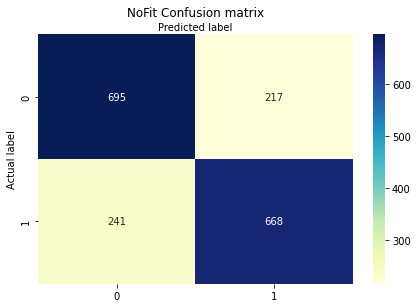

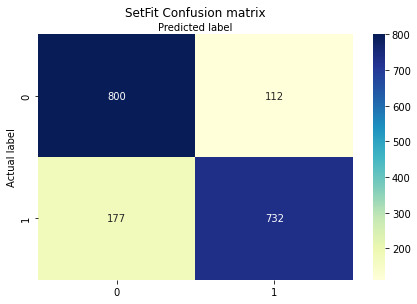

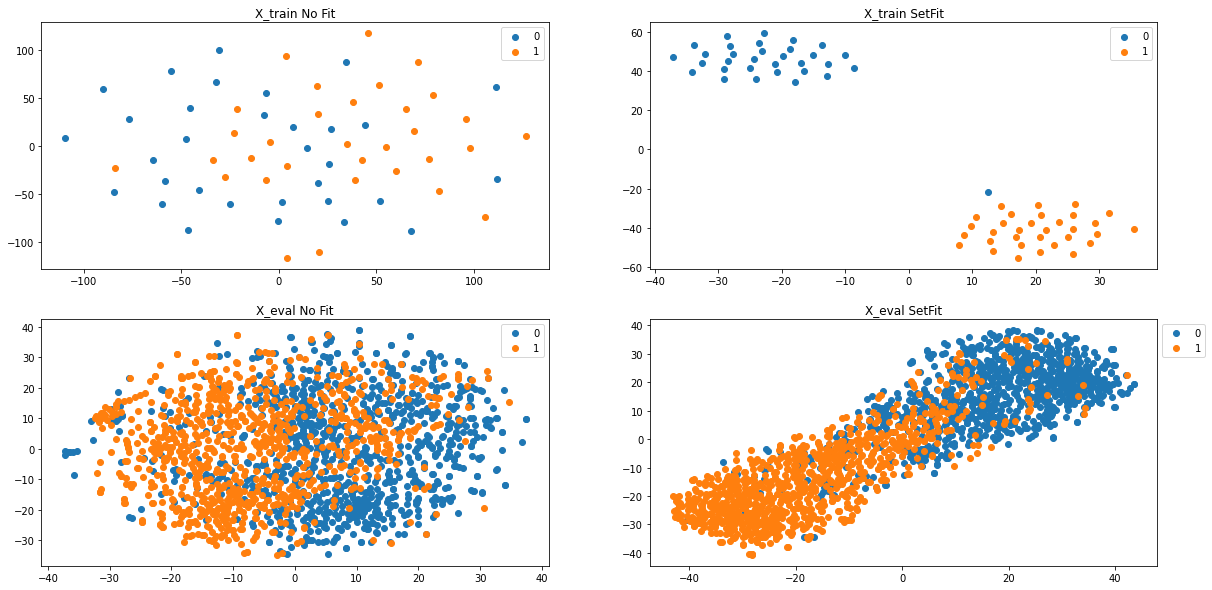

In [71]:
eval(x_train, x_eval, y_train, y_eval)

## German Text Classification

### Ger Data Preparation

In [74]:
%env DIR=../../data

!mkdir -p $DIR
!wget -nc https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O $DIR/train.csv
!wget -nc https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O $DIR/test.csv
!ls -lAh $DIR | cut -d " " -f 5-

env: DIR=../../data
2022-10-19 13:41:02 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv [24405789/24405789] -> "../../data/train.csv" [1]
2022-10-19 13:41:05 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv [2755020/2755020] -> "../../data/test.csv" [1]

2.7M Oct 19 13:41 test.csv
 24M Oct 19 13:41 train.csv


In [75]:
data_path = Path('../../data/')

train_file = data_path / "train.csv"
test_file = data_path / "test.csv"

In [76]:
def load_10kGNAD(filepath: Path, columns: list=["labels", "text"]) -> pd.DataFrame:
    """Load 10kGNAD-specific data format from CVS file."""
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=columns)
    return f

In [77]:
# load the dataset splits
ger_train_df = load_10kGNAD(train_file)
ger_eval_df = load_10kGNAD(test_file)

In [78]:
text_col=ger_train_df.columns.values[1] 
category_col=ger_train_df.columns.values[0]
# text and label column indentifiers

x_eval = ger_eval_df[text_col].values.tolist()
y_eval = ger_eval_df[category_col].values.tolist()

In [79]:
values, count = np.unique(y_eval, return_counts=True)
values, count # classes are unbalanced in test set

(array(['Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport',
        'Web', 'Wirtschaft', 'Wissenschaft'], dtype='<U13'),
 array([ 67, 102, 151,  54, 168, 120, 168, 141,  57]))

#### Map multi class labels to int

In [80]:
ger_train_df['labels'] = ger_train_df['labels'].astype('category')

In [81]:
cats = ger_train_df['labels'].cat.categories.values
ncats = len(cats)

In [82]:
multiclass_dict = dict(zip(cats, range(ncats)))
multiclass_dict

{'Etat': 0,
 'Inland': 1,
 'International': 2,
 'Kultur': 3,
 'Panorama': 4,
 'Sport': 5,
 'Web': 6,
 'Wirtschaft': 7,
 'Wissenschaft': 8}

In [83]:
ger_train_df['labels'] = ger_train_df['labels'].map(multiclass_dict)
ger_eval_df['labels'] = ger_eval_df['labels'].map(multiclass_dict)

In [84]:
ger_train_df

,labels,text
0,5,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,3,"Erfundene Bilder zu Filmen, die als verloren g..."
2,6,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,7,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,1,Estland sieht den künftigen österreichischen P...
...,...,...
9240,1,Bernd Saurer war Bridge-Juniorenweltmeister un...
9241,2,Sandhere soll in vergangener Woche bei Luftang...
9242,7,Derzeit Konzeptgruppe in Berlin – Kein Komment...
9243,1,Landeshauptmann will den vierten Regierungssit...


### Parallel Dataset & Params

In [90]:
st_model = "airnicco8/xlm-roberta-en-it-de" #@param ["airnicco8/xlm-roberta-en-it-de"]
num_training = 4 #@param ["4", "8", "16", "32", "64", "128", "256", "512"] {type:"raw"}
num_itr = 3 #@param ["1", "2", "3", "4", "5", "10"] {type:"raw"}
classifier = "SGDClassifier" #@param ["LogisticRegression", "SGDClassifier"]
plot2d_checkbox = True #@param {type: 'boolean'}

set_seed(0)
# Equal samples per class training
train_df_sample = pd.concat([ger_train_df[ger_train_df[category_col]==0].sample(1), ger_train_df[ger_train_df[category_col]==6].sample(1)])
# do forma al dataframe per inizializzarlo
for i in range(ncats):
  other_classes = list(set(range(ncats))-set([i])) # fermo la classe di riferimento
  for j in other_classes:
    try:
      tmp = pd.concat([ger_train_df[ger_train_df[category_col]==i].sample(num_training), ger_train_df[ger_train_df[category_col]==j].sample(num_training)])
    except:
      print(i, j)
    # aggiungo num_training sample negativi per ogni altra classe
    train_df_sample=train_df_sample.append(tmp)

train_df_sample=train_df_sample.drop(train_df_sample.index[0:2].values)
# rimuovo le prime 2 righe che hanno inizializzato

x_train = train_df_sample[text_col].values.tolist()
y_train = train_df_sample[category_col].values.tolist()

train_examples = [] 
for x in range(num_itr):
  train_examples = sentence_pairs_generation(np.array(x_train), np.array(y_train), train_examples)


In [91]:
len(train_examples)

3456

### Ger Training

In [ ]:
orig_model = SentenceTransformer(st_model)
model = SentenceTransformer(st_model)

# S-BERT adaptation 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=10, show_progress_bar=True)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/216 [00:00<?, ?it/s]

### Ger Evaluation

In [ ]:
eval(x_train, x_eval, y_train, y_eval)

# Mono Lingual German Student

## German Text Classification

### Params

In [2]:
st_model = "airnicco8/xlm-roberta-de" #@param ["airnicco8/xlm-roberta-de"]
num_itr = 5 #@param ["1", "2", "3", "4", "5", "10"] {type:"raw"}
plot2d_checkbox = True #@param {type: 'boolean'}

### Ger Training

In [ ]:
orig_model = SentenceTransformer(st_model)
model = SentenceTransformer(st_model)

# S-BERT adaptation 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=10, show_progress_bar=True)

# No Fit
X_train_noFT = orig_model.encode(x_train)
X_eval_noFT = orig_model.encode(x_eval)

sgd =  LogisticRegression()
sgd.fit(X_train_noFT, y_train)
y_pred_eval_sgd = sgd.predict(X_eval_noFT)

print('Acc. No Fit', accuracy_score(y_eval, y_pred_eval_sgd))
print('F1 No Fit', f1_score(y_eval, y_pred_eval_sgd))

# With Fit (SetFit)
X_train = model.encode(x_train)
X_eval = model.encode(x_eval)

sgd =  LogisticRegression()
sgd.fit(X_train, y_train)
y_pred_eval_sgd = sgd.predict(X_eval)

print('Acc. SetFit', accuracy_score(y_eval, y_pred_eval_sgd))
print('F1 SetFit', f1_score(y_eval, y_pred_eval_sgd))

#Plot 2-D 2x2 figures
if plot2d_checkbox:   

  plt.figure(figsize=(20,10))

#Plot X_train_noFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train_noFT))
  plt.subplot(221)
  plt.title('X_train No Fit')

  for i, t in enumerate(set(np.array(y_train))):
      idx = np.array(y_train) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));

#Plot X_eval noFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval_noFT))
  plt.subplot(223)
  plt.title('X_eval No Fit')

  for i, t in enumerate(set(np.array(y_eval))):
      idx = np.array(y_eval) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));


#Plot X_train SetFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train))

  plt.subplot(222)
  plt.title('X_train SetFit')

  for i, t in enumerate(set(np.array(y_train))):
      idx = np.array(y_train) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));

#Plot X_eval SetFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval))
  plt.subplot(224)
  plt.title('X_eval SetFit')

  for i, t in enumerate(set(np.array(y_eval))):
      idx = np.array(y_eval) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1440 [00:00<?, ?it/s]

KeyboardInterrupt: ignored